# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить **модель для определения стоимости**. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных из документации:

*Признаки*
<br>`DateCrawled` — дата скачивания анкеты из базы
<br>`VehicleType` — тип автомобильного кузова
<br>`RegistrationYear` — год регистрации автомобиля
<br>`Gearbox` — тип коробки передач
<br>`Power` — мощность (л. с.)
<br>`Model` — модель автомобиля
<br>`Kilometer` — пробег (км)
<br>`RegistrationMonth` — месяц регистрации автомобиля
<br>`FuelType` — тип топлива
<br>`Brand` — марка автомобиля
<br>`NotRepaired` — была машина в ремонте или нет
<br>`DateCreated` — дата создания анкеты
<br>`NumberOfPictures` — количество фотографий автомобиля
<br>`PostalCode` — почтовый индекс владельца анкеты (пользователя)
<br>`LastSeen` — дата последней активности пользователя

*Целевой признак*
<br>`Price` — цена (евро)

План работ:
1. Загрузим данные (`autos.csv`).
2. Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные признаки.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — **LightGBM**, и как минимум одна — не бустинг. (Иногда более простые модели работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.) Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Примечания:
- Для оценки качества моделей применим метрику RMSE.
- Значение RMSE должно быть меньше 2500.

## Библиотеки

In [1]:
#pip install catboost

In [2]:
#pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
# import seaborn as sns
import os
from catboost import CatBoostRegressor #, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
import warnings

In [2]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 11:35'

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

## Подготовка данных

In [4]:
pth1 = '/datasets/'
pth2 = ''
fname = 'autos.csv'
if os.path.exists(pth1+fname):
    df = pd.read_csv(pth1+fname)
elif os.path.exists(pth2+fname):
    df = pd.read_csv(pth2+fname)
else:
    print('Something is wrong')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


354369 строк, 16 столбцов. Есть пропуски в данных.

### Названия столбцов

In [7]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Даты

In [8]:
df.registration_month.value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registration_month, dtype: int64

In [9]:
df.registration_year.value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: registration_year, Length: 151, dtype: int64

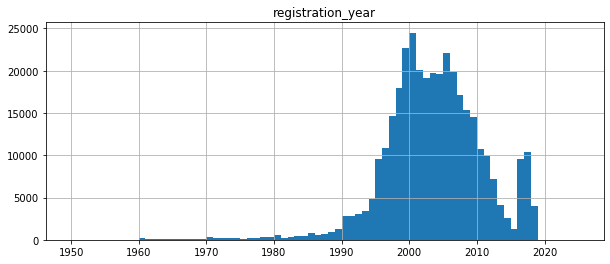

In [10]:
df.hist(column='registration_year', figsize=(10,4), bins=75, range=(1950,2025));

In [11]:
df["date_crawled_2"] = pd.to_datetime(df.date_crawled, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df["date_created_2"] = pd.to_datetime(df.date_created, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df["last_seen_2"] = pd.to_datetime(df.last_seen, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

df["reg_date"] = [(dt.datetime(1900,1,1) if ((x < 1950) or (x > 2020)) else dt.datetime(x, (1 if (y==0) else y), 1)) for x, y in zip(df.registration_year, df.registration_month)]

In [12]:
# df['reg_date_year'] = df['reg_date'].dt.year
# df['reg_date_month'] = df['reg_date'].dt.month

# df['last_seen_year'] = df['last_seen_2'].dt.year
# df['last_seen_month'] = df['last_seen_2'].dt.month
# df['last_seen_day'] = df['last_seen_2'].dt.day

df['created_year'] = df['date_created_2'].dt.year
df['created_month'] = df['date_created_2'].dt.month
df['created_day'] = df['date_created_2'].dt.day

# df['crawled_year'] = df['date_crawled_2'].dt.year
# df['crawled_month'] = df['date_crawled_2'].dt.month
# df['crawled_day'] = df['date_crawled_2'].dt.day

In [13]:
df['delta_reg_post_days'] = (df['date_created_2'] - df['reg_date'].where(
df.registration_year > 1950, df['date_created_2'])).dt.total_seconds()/(60*60*24)

In [14]:
df.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,...,postal_code,last_seen,date_crawled_2,date_created_2,last_seen_2,reg_date,created_year,created_month,created_day,delta_reg_post_days
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,...,70435,2016-04-07 03:16:57,2016-03-24 11:52:17,2016-03-24,2016-04-07 03:16:57,1993-01-01,2016,3,24,8483.0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,66954,2016-04-07 01:46:50,2016-03-24 10:58:45,2016-03-24,2016-04-07 01:46:50,2011-05-01,2016,3,24,1789.0


In [15]:
df.delta_reg_post_days.value_counts()

0.0        294
5913.0     266
5933.0     257
5917.0     256
5938.0     248
          ... 
19619.0      1
19617.0      1
322.0        1
16000.0      1
13941.0      1
Name: delta_reg_post_days, Length: 15243, dtype: int64

### Пропуски данных

In [16]:
df.isna().sum()

date_crawled               0
price                      0
vehicle_type           37490
registration_year          0
gearbox                19833
power                      0
model                  19705
kilometer                  0
registration_month         0
fuel_type              32895
brand                      0
not_repaired           71154
date_created               0
number_of_pictures         0
postal_code                0
last_seen                  0
date_crawled_2             0
date_created_2             0
last_seen_2                0
reg_date                   0
created_year               0
created_month              0
created_day                0
delta_reg_post_days        0
dtype: int64

In [17]:
df.model.value_counts(dropna=False).head(20)

golf           29232
other          24421
3er            19761
NaN            19705
polo           13066
corsa          12570
astra          10809
passat         10146
a4              9900
c_klasse        8312
5er             7868
e_klasse        6785
a3              6122
focus           5874
fiesta          5774
a6              5541
twingo          4953
transporter     4822
2_reihe         4816
fortwo          4337
Name: model, dtype: int64

In [18]:
df.model.value_counts(dropna=False).tail(10)

gl                    13
samara                13
elefantino            11
kalina                 9
i3                     8
serie_2                8
serie_3                4
rangerover             4
serie_1                2
range_rover_evoque     2
Name: model, dtype: int64

In [19]:
df.model = df.model.fillna('unknown')

In [20]:
df.not_repaired.value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: not_repaired, dtype: int64

In [21]:
df.not_repaired = df.not_repaired.fillna('unknown')

In [22]:
df.fuel_type.value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [23]:
common_fuel = pd.DataFrame(df['fuel_type'].groupby(df['model']
                                                  ).value_counts(dropna=False).groupby(
    level=0).nlargest(1).reset_index(level=0, drop=True))
common_fuel.columns = ['cnt']
common_fuel.reset_index(drop=False, inplace=True)
common_fuel_dict = pd.Series(common_fuel[['model','fuel_type']].set_index('model')['fuel_type']).to_dict()
common_fuel_dict
common_fuel_column = df.model.apply(lambda x: common_fuel_dict[x])
df['fuel_type'] = df['fuel_type'].fillna(common_fuel_column)

In [24]:
df.vehicle_type.value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [25]:
common_vehicle = pd.DataFrame(df['vehicle_type'].groupby(df['model']
                                                        ).value_counts(dropna=False).groupby(
    level=0).nlargest(1).reset_index(level=0, drop=True))
common_vehicle.columns = ['cnt']
common_vehicle.reset_index(drop=False, inplace=True)
common_vehicle_dict = pd.Series(common_vehicle[['model','vehicle_type']].set_index('model')['vehicle_type']).to_dict()
common_vehicle_dict
common_vehicle_column = df.model.apply(lambda x: common_vehicle_dict[x])
df['vehicle_type'] = df['vehicle_type'].fillna(common_vehicle_column)

In [26]:
df.gearbox.value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: gearbox, dtype: int64

In [27]:
common_gearbox = pd.DataFrame(df['gearbox'].groupby(df['model']
                                                        ).value_counts(dropna=False).groupby(
    level=0).nlargest(1).reset_index(level=0, drop=True))
common_gearbox.columns = ['cnt']
common_gearbox.reset_index(drop=False, inplace=True)
common_gearbox_dict = pd.Series(common_gearbox[['model','gearbox']].set_index('model')['gearbox']).to_dict()
common_gearbox_dict
common_gearbox_column = df.model.apply(lambda x: common_gearbox_dict[x])
df['gearbox'] = df['gearbox'].fillna(common_gearbox_column)

In [28]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type           6838
registration_year         0
gearbox                   1
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
not_repaired              0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
date_crawled_2            0
date_created_2            0
last_seen_2               0
reg_date                  0
created_year              0
created_month             0
created_day               0
delta_reg_post_days       0
dtype: int64

In [29]:
df.vehicle_type = df.vehicle_type.fillna('unknown')
df.dropna(inplace=True)
df.isna().sum()

date_crawled           0
price                  0
vehicle_type           0
registration_year      0
gearbox                0
power                  0
model                  0
kilometer              0
registration_month     0
fuel_type              0
brand                  0
not_repaired           0
date_created           0
number_of_pictures     0
postal_code            0
last_seen              0
date_crawled_2         0
date_created_2         0
last_seen_2            0
reg_date               0
created_year           0
created_month          0
created_day            0
delta_reg_post_days    0
dtype: int64

In [30]:
df.brand.value_counts().sort_index(ascending=True)

alfa_romeo         2314
audi              29456
bmw               36914
chevrolet          1754
chrysler           1439
citroen            5148
dacia               900
daewoo              542
daihatsu            806
fiat               9643
ford              25179
honda              2817
hyundai            3587
jaguar              505
jeep                677
kia                2465
lada                225
lancia              471
land_rover          544
mazda              5615
mercedes_benz     32046
mini               3202
mitsubishi         3022
nissan             4941
opel              39931
peugeot           10998
porsche             758
renault           17927
rover               486
saab                526
seat               6907
skoda              5500
smart              5246
sonstige_autos     3374
subaru              762
suzuki             2323
toyota             4606
trabant             589
volkswagen        77013
volvo              3210
Name: brand, dtype: int64

### Выбросы

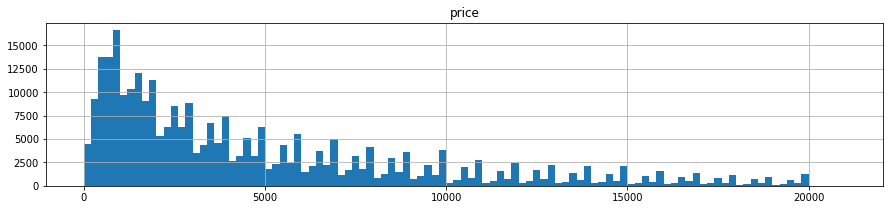

In [215]:
df.hist(column='price', figsize=(15,3), bins=105, range=(1,21000));

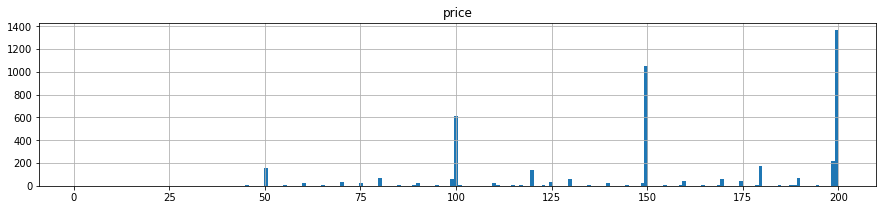

In [211]:
df.hist(column='price', figsize=(15,3), bins=200, range=(1,200));

In [32]:
df.price.describe()

count    354368.000000
mean       4416.669239
std        4514.158786
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [33]:
df = df.query("price > 40")
df.price.describe()

count    341975.000000
mean       4576.698607
std        4514.844784
min          45.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [34]:
df.power.describe()

count    341975.000000
mean        111.201886
std         188.248947
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

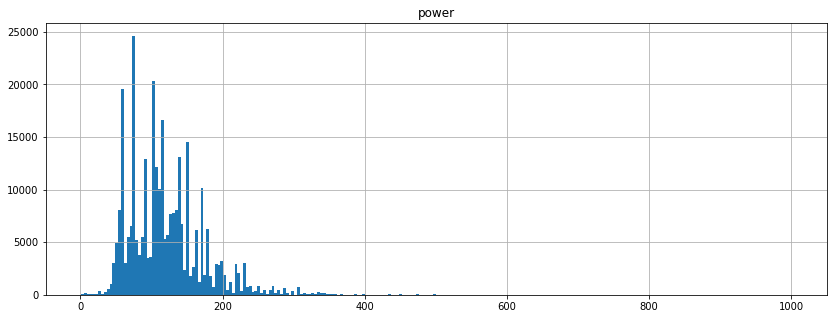

In [35]:
df.hist(column='power', figsize=(14,5), bins=250, range=(1,1000));

In [36]:
df = df.query("(power > 0) and (power <= 600)")
df.power.describe()

count    306066.000000
mean        120.203133
std          53.792629
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         600.000000
Name: power, dtype: float64

In [37]:
df.kilometer.describe()

count    306066.000000
mean     128413.152719
std       36723.427117
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [93]:
df.number_of_pictures.describe()

count    295759.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

In [94]:
df.drop(columns=['number_of_pictures'], inplace=True)

In [39]:
df.registration_year.describe()

count    306066.000000
mean       2003.504747
std          30.073383
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [40]:
df.date_crawled_2.describe()

count                  306066
unique                 243180
top       2016-03-19 21:49:56
freq                        6
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: date_crawled_2, dtype: object

In [41]:
df.date_created_2.describe()

count                  306066
unique                    107
top       2016-04-03 00:00:00
freq                    12070
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: date_created_2, dtype: object

In [44]:
df.query('registration_year < 1950 or registration_year > 2016')#.registration_year.value_counts()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,...,postal_code,last_seen,date_crawled_2,date_created_2,last_seen_2,reg_date,created_year,created_month,created_day,delta_reg_post_days
22,2016-03-23 14:52:51,2900,bus,2018,manual,90,meriva,150000,5,petrol,...,49716,2016-03-31 01:16:33,2016-03-23 14:52:51,2016-03-23,2016-03-31 01:16:33,2018-05-01,2016,3,23,-769.0
26,2016-03-10 19:38:18,5555,sedan,2017,manual,125,c4,125000,4,gasoline,...,31139,2016-03-16 09:16:46,2016-03-10 19:38:18,2016-03-10,2016-03-16 09:16:46,2017-04-01,2016,3,10,-387.0
48,2016-03-25 14:40:12,7750,sedan,2017,manual,80,golf,100000,1,petrol,...,48499,2016-03-31 21:47:44,2016-03-25 14:40:12,2016-03-25,2016-03-31 21:47:44,2017-01-01,2016,3,25,-282.0
51,2016-03-07 18:57:08,2000,small,2017,manual,90,punto,150000,11,gasoline,...,66115,2016-03-07 18:57:08,2016-03-07 18:57:08,2016-03-07,2016-03-07 18:57:08,2017-11-01,2016,3,7,-604.0
57,2016-03-10 20:53:19,2399,sedan,2018,manual,64,other,125000,3,petrol,...,33397,2016-03-25 10:17:37,2016-03-10 20:53:19,2016-03-10,2016-03-25 10:17:37,2018-03-01,2016,3,10,-721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354099,2016-03-17 15:45:46,4900,small,2017,manual,69,polo,150000,12,gasoline,...,32791,2016-03-25 17:51:29,2016-03-17 15:45:46,2016-03-17,2016-03-25 17:51:29,2017-12-01,2016,3,17,-624.0
354112,2016-03-11 15:49:51,3600,bus,2017,manual,86,transit,150000,5,gasoline,...,32339,2016-03-12 05:45:02,2016-03-11 15:49:51,2016-03-11,2016-03-12 05:45:02,2017-05-01,2016,3,11,-416.0
354140,2016-03-29 16:47:29,1000,wagon,2017,manual,101,a4,150000,9,gasoline,...,38315,2016-04-06 02:44:27,2016-03-29 16:47:29,2016-03-29,2016-04-06 02:44:27,2017-09-01,2016,3,29,-521.0
354203,2016-03-17 00:56:26,2140,small,2018,manual,80,fiesta,150000,6,petrol,...,44866,2016-03-29 15:45:04,2016-03-17 00:56:26,2016-03-17,2016-03-29 15:45:04,2018-06-01,2016,3,17,-806.0


In [45]:
df = df.query('registration_year > 1950 and registration_year <= 2016')

In [46]:
df.query('reg_date > date_crawled_2')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,...,postal_code,last_seen,date_crawled_2,date_created_2,last_seen_2,reg_date,created_year,created_month,created_day,delta_reg_post_days
31,2016-03-29 16:57:02,899,small,2016,manual,60,clio,150000,6,petrol,...,37075,2016-03-29 17:43:07,2016-03-29 16:57:02,2016-03-29,2016-03-29 17:43:07,2016-06-01,2016,3,29,-64.0
35,2016-03-08 07:54:46,350,sedan,2016,manual,75,golf,150000,4,petrol,...,19386,2016-03-08 09:44:50,2016-03-08 07:54:46,2016-03-08,2016-03-08 09:44:50,2016-04-01,2016,3,8,-24.0
200,2016-04-03 20:44:13,1999,sedan,2016,manual,110,almera,150000,9,gasoline,...,10997,2016-04-05 21:17:18,2016-04-03 20:44:13,2016-04-03,2016-04-05 21:17:18,2016-09-01,2016,4,3,-151.0
294,2016-03-10 20:43:12,2390,small,2016,manual,83,jazz,150000,12,petrol,...,78713,2016-03-13 03:17:27,2016-03-10 20:43:12,2016-03-10,2016-03-13 03:17:27,2016-12-01,2016,3,10,-266.0
428,2016-04-02 18:42:54,1299,sedan,2016,manual,75,astra,150000,5,petrol,...,59425,2016-04-02 18:42:54,2016-04-02 18:42:54,2016-04-02,2016-04-02 18:42:54,2016-05-01,2016,4,2,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353895,2016-03-08 08:56:13,350,sedan,2016,manual,60,3_reihe,150000,10,petrol,...,20359,2016-03-08 22:17:16,2016-03-08 08:56:13,2016-03-08,2016-03-08 22:17:16,2016-10-01,2016,3,8,-207.0
354068,2016-03-17 22:06:35,3700,sedan,2016,manual,90,golf,150000,4,gasoline,...,55122,2016-03-19 16:30:51,2016-03-17 22:06:35,2016-03-17,2016-03-19 16:30:51,2016-04-01,2016,3,17,-15.0
354107,2016-03-09 12:51:50,395,sedan,2016,manual,60,golf,150000,12,petrol,...,25575,2016-04-05 23:45:21,2016-03-09 12:51:50,2016-03-09,2016-04-05 23:45:21,2016-12-01,2016,3,9,-267.0
354115,2016-03-07 11:59:24,299,sedan,2016,manual,60,astra,150000,4,petrol,...,49326,2016-03-20 01:46:49,2016-03-07 11:59:24,2016-03-07,2016-03-20 01:46:49,2016-04-01,2016,3,7,-25.0


Тоже какие-то ошибки, но, возможно, некритичные, технические. Оставим эти данные.

In [95]:
df.shape

(295759, 23)

### Признаки

Отберём в features только те признаки, которые могут влиять на целевой признак.

In [47]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen', 'date_crawled_2', 'date_created_2',
       'last_seen_2', 'reg_date', 'created_year', 'created_month',
       'created_day', 'delta_reg_post_days'],
      dtype='object')

#### features, target

In [96]:
target = df['price']
features = df[[
    'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'
    , 'registration_year', 'registration_month'
    , 'created_year'
   , 'delta_reg_post_days'
   , 'power', 'kilometer'
              ]]

In [97]:
target.mean()

4866.530232385151

#### split

In [98]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    shuffle=True,
    random_state=324819)

print(features_train.shape) 
print(features_test.shape) 
print('\n', target_train.mean(), target_test.mean(), sep='\t')

(236607, 12)
(59152, 12)

	4867.496456148804	4862.665353665134


#### Масштабирование

In [99]:
numeric = ['delta_reg_post_days', 'power', 'kilometer'
#            , 'number_of_pictures'
          , 'registration_year'
           , 'created_year'
          ]

In [100]:
# scaler = StandardScaler(with_std=True)
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train.loc[:,numeric] = scaler.transform(features_train[numeric])
features_test.loc[:,numeric] = scaler.transform(features_test[numeric])

C:\Users\skysh\.conda\envs\praktikum\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\skysh\.conda\envs\praktikum\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Кодирование

In [101]:
categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
# categorial_short = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

In [102]:
encoder = OrdinalEncoder()
encoder.fit(features_train[categorial])

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe.loc[:,categorial] = encoder.transform(features_train[categorial])
features_test_oe.loc[:,categorial] = encoder.transform(features_test[categorial])

features_train_oe.head(2)

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,registration_year,registration_month,created_year,delta_reg_post_days,power,kilometer
105596,8.0,1.0,149.0,6.0,27.0,0.0,0.861538,8,1.0,0.141885,0.183639,1.000000
281095,5.0,1.0,173.0,6.0,38.0,0.0,0.907692,11,1.0,0.092640,0.141903,0.310345


In [189]:
features_train_ohe = pd.get_dummies(features_train#.drop(columns=['model','brand'])
                                    , drop_first=True)
# features_train_ohe['model'] = features_train_oe['model']
# features_train_ohe['brand'] = features_train_oe['brand']

features_test_ohe = pd.get_dummies(features_test#.drop(columns=['model','brand'])
                                   , drop_first=True)
# features_test_ohe['model'] = features_test_oe['model']
# features_test_ohe['brand'] = features_test_oe['brand']

features_train_ohe.head(2)

,registration_year,registration_month,created_year,delta_reg_post_days,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
105596,0.861538,8,1.0,0.141885,0.183639,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281095,0.907692,11,1.0,0.092640,0.141903,0.310345,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [190]:
features_test_ohe.head(2)

,registration_year,registration_month,created_year,delta_reg_post_days,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
36087,0.630769,3,1.0,0.375871,0.202003,1.000000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
171826,0.830769,5,1.0,0.175573,0.111853,0.586207,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Не совпало кол-во столбцов.

In [195]:
features_test_ohe.shape

(59152, 306)

Добавим недостающие столбцы, заполненные нулями:

In [194]:
lack_cols = set(features_train_ohe.columns.values) - set(features_test_ohe.columns.values)
lack_cols

{'model_i3',
 'model_range_rover_evoque',
 'model_rangerover',
 'model_samara',
 'model_serie_3'}

In [196]:
for col in lack_cols:
    features_test_ohe[col] = np.zeros(features_test_ohe.shape[0])
features_test_ohe.head(2)

,registration_year,registration_month,created_year,delta_reg_post_days,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes,model_serie_3,model_range_rover_evoque,model_rangerover,model_i3,model_samara
36087,0.630769,3,1.0,0.375871,0.202003,1.000000,0,0,0,1,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
171826,0.830769,5,1.0,0.175573,0.111853,0.586207,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


Синхронизируем порядок столбцов:

In [202]:
features_test_ohe = features_test_ohe[features_train_ohe.columns.values]
# features_test_ohe.columns.values

<div class="alert alert-block alert-info">
<b>Комментарий студента: Как можно решить проблему выше (разное кол-во столбцов) изящнее?</b>
    Это, должно быть, из-за того, что не все возможные модели авто попали в тестовую выборку. Но такая ситуация сама по себе наверно нормальна? Моделей же довольно много.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий ревьюера:</b>

Можно выполнить кодирование перед разбиением на выборки
</div>

#### split 2

In [122]:
features_train_ohe_small, features_valid_ohe, target_train_ohe_small, target_valid_ohe = train_test_split(
    features_train_ohe, target_train, 
    test_size=0.2, 
    shuffle=True,
    random_state=242892457)

print(features_train_ohe_small.shape) 
print(features_valid_ohe.shape) 
print('\n', target_train_ohe_small.mean(), target_valid_ohe.mean(), sep='\t')

(189285, 311)
(47322, 311)

	4866.498993581108	4871.486243184988


In [120]:
features_train_oe_small, features_valid_oe, target_train_oe_small, target_valid_oe = train_test_split(
    features_train_oe, target_train, 
    test_size=0.2, 
    shuffle=True,
    random_state=273865)

print(features_train_oe_small.shape) 
print(features_valid_oe.shape) 
print('\n', target_train_oe_small.mean(), target_valid_oe.mean(), sep='\t')

(189285, 12)
(47322, 12)

	4867.635290699211	4866.9411267486585


## Обучение моделей

### Линейная регрессия

In [104]:
# %%time

# lr_model = LinearRegression(n_jobs=4, )

# params = dict(fit_intercept=[True,False], 
#               normalize=[True,False]
#              )
# grid = GridSearchCV(lr_model, params, verbose=1, 
#                     scoring='neg_mean_squared_error', 
#                     cv=3, 
#                     n_jobs=4
#                    )
# grid.fit(features_train_ohe, target_train)

# print('\n', grid.best_params_)
# print('\nscore:', ((-1)*grid.best_score_)**0.5)
# best_lr = grid.best_estimator_
# # print(best_lr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'fit_intercept': True, 'normalize': False}
score: 2607.0750983124067
LinearRegression(n_jobs=4, normalize=False)
Wall time: 1min 1s


`{'fit_intercept': True, 'normalize': False}`

In [169]:
best_lr = LinearRegression(n_jobs=4, fit_intercept=True, normalize=False);

In [184]:
%%time
best_lr.fit(features_train_ohe_small, target_train_ohe_small)

Wall time: 5.91 s


LinearRegression(n_jobs=4, normalize=False)

In [185]:
%%time
predicted_lr = best_lr.predict(features_valid_ohe)

Wall time: 79.4 ms


In [186]:
print(f"\nRMSE: {mean_squared_error(target_valid_ohe, predicted_lr)**0.5:3.2f}\n")


RMSE: 2600.16



### Гребневая регрессия

In [ ]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M")

In [50]:
features_train.to_numpy().flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [51]:
target_train.to_numpy().flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [109]:
%%time

ridge_model = Ridge(random_state=5478623) # n_jobs=4

params = dict(fit_intercept=[True,False],
              alpha=np.linspace(0.2, 1, num=16),
              tol=[0.001],
              solver=['auto', 'svd', 'cholesky'] #, 'lsqr', 'sparse_cg', 'sag', 'saga' ],  #, 'lbfgs'
             )
grid = RandomizedSearchCV(ridge_model, params, verbose=1, 
                          scoring='neg_mean_squared_error', 
                          cv=5, 
                          n_jobs=4, 
                          n_iter = 10
                         ) 
grid.fit(features_train_ohe.to_numpy().copy(order='C'), 
         target_train)

print('\n', grid.best_params_)
print('\nscore:', ((-1)*grid.best_score_)**0.5)
best_r = grid.best_estimator_
# print(model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

 {'tol': 0.001, 'solver': 'svd', 'fit_intercept': True, 'alpha': 0.25333333333333335}

score: 2608.836824702709
Wall time: 6min 35s


In [128]:
%%time
best_r.fit(features_train_ohe_small, target_train_ohe_small)

Wall time: 17.3 s


Ridge(alpha=0.25333333333333335, random_state=5478623, solver='svd')

In [129]:
%%time
predicted_r = best_r.predict(features_valid_ohe)

Wall time: 156 ms


In [130]:
print(f"\nRMSE: {mean_squared_error(target_valid_ohe, predicted_r)**0.5:3.2f}\n")


RMSE: 2602.19



In [134]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 13:06:33'

### CatBoost

In [135]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 13:06:35'

In [137]:
%%time

cat_model = CatBoostRegressor(iterations=750, loss_function="RMSE", eval_metric='RMSE', verbose=0, thread_count=4)

params = {'learning_rate': np.linspace(0.15, 0.3, num=7), 
          'depth': range(6,9), 
          'l2_leaf_reg': range(1,4), 
#           'verbose': [0] 
         }

#grid_search_result = 
cat_model.randomized_search(params, X=features_train_oe, y=target_train,
                            cv=4, n_iter=28,
                            partition_random_seed=1234, 
                            verbose=10, plot=True
                           );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1583.957706
bestIteration = 747

0:	loss: 1583.9577061	best: 1583.9577061 (0)	total: 33.8s	remaining: 15m 11s

bestTest = 1572.841409
bestIteration = 749


bestTest = 1571.836632
bestIteration = 749


bestTest = 1568.07294
bestIteration = 749


bestTest = 1564.670676
bestIteration = 749


bestTest = 1566.426137
bestIteration = 749


bestTest = 1586.575943
bestIteration = 749


bestTest = 1574.419953
bestIteration = 749


bestTest = 1587.134165
bestIteration = 749


bestTest = 1581.323576
bestIteration = 749


bestTest = 1574.891611
bestIteration = 749

10:	loss: 1574.8916107	best: 1564.6706758 (4)	total: 6m 6s	remaining: 9m 26s

bestTest = 1566.681761
bestIteration = 748


bestTest = 1554.666087
bestIteration = 725


bestTest = 1566.455608
bestIteration = 749


bestTest = 1553.802655
bestIteration = 749


bestTest = 1565.922937
bestIteration = 749


bestTest = 1560.014752
bestIteration = 749


bestTest = 1560.864257
bestIteration = 749


bestTest = 1548.083407
bestIteration

{'params': {'depth': 8,
  'l2_leaf_reg': 1,
  'learning_rate': 0.27499999999999997},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
    

`Wall time: 32min 47s
 RMSE: 1539.691128
 {'params': {'depth': 8,
  'l2_leaf_reg': 1,
  'learning_rate': 0.27499999999999997}`

In [139]:
print(cat_model.get_best_score())
cat_model.get_params()

{'learn': {'RMSE': 1286.3248178215963}}


{'iterations': 750,
 'loss_function': 'RMSE',
 'thread_count': 4,
 'verbose': 0,
 'eval_metric': 'RMSE',
 'depth': 8,
 'l2_leaf_reg': 1,
 'learning_rate': 0.27499999999999997}

In [141]:
%%time
cat_model.fit(features_train_oe_small, target_train_oe_small);

Wall time: 45.7 s


In [142]:
%%time
predicted_cat = cat_model.predict(features_valid_oe)

Wall time: 54.3 ms


In [143]:
print(f"\nRMSE: {mean_squared_error(target_valid_oe, predicted_cat)**0.5:3.2f}\n")


RMSE: 1534.55



In [144]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 13:44'

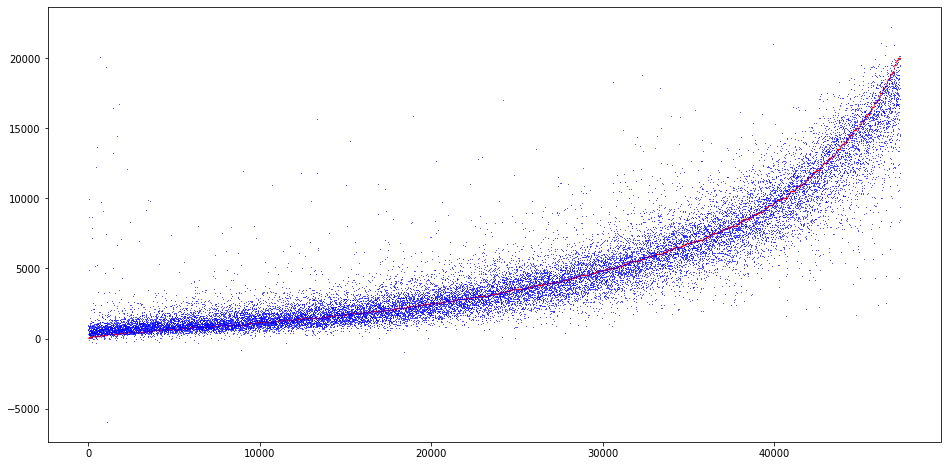

In [146]:
x = range(target_valid_oe.size)
idx = np.argsort(target_valid_oe)
y1 = np.array(target_valid_oe)[idx]
y2 = np.array(predicted_cat)[idx]

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(x, y1, figure=fig, color='red', marker='o', markersize=0.05, linestyle='-', linewidth=0.005,
        alpha=1, markevery=2) 
plt.plot(x, y2, figure=fig, color='blue', marker='o', markersize=0.0000008, linestyle=' ',
        alpha=0.7, markevery=2) 
plt.show();

### LightGBM

In [ ]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

In [153]:
%%time

lgbm_model = LGBMRegressor(random_state=542989)

params = {'learning_rate': np.linspace(0.375, 0.425, num=5),
          'n_estimators': [400], 
          'num_leaves': [41, 43, 45], 
          'max_depth': [14,15], 
          'boosting_type': ['dart'],  #'gbdt', 'goss'
          'reg_lambda': np.linspace(0.39, 0.43, num=5), 
          
          'metric': ['rmse'], 
          'verbose': [1], 
         }

grid = RandomizedSearchCV(lgbm_model, params, verbose=10, 
                          scoring='neg_mean_squared_error', 
                          cv=3, 
                          n_iter=20, 
                          n_jobs=4)
grid.fit(features_train_oe, target_train)

print('\n', grid.best_params_)
print('\nscore:', ((-1)*grid.best_score_)**0.5)
best_lgbm = grid.best_estimator_
# print(model)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.777927
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.156934
[LightGBM] [Debug] init for col-wise cost 0.003389 seconds, init for row-wise cost 0.004731 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 236607, number of used features: 11
[LightGBM] [Info] Start training from score 4867.496456
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 9
[LightGBM] [Debug] Trained a t

`Fitting 3 folds for each of 16 candidates, totalling 48 fits
 {'verbose': 0, 'reg_lambda': 0.41250000000000003, 'num_leaves': 43, 'n_estimators': 300, 'metric': 'rmse', 'max_depth': 14,  'learning_rate': 0.4, 'boosting_type': 'dart'}
 score: 1560.6662220511855
 Wall time: 4min 11s`

In [154]:
%%time
best_lgbm.fit(features_train_oe_small, target_train_oe_small);

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.777890
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.156976
[LightGBM] [Debug] init for col-wise cost 0.003011 seconds, init for row-wise cost 0.003762 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 189285, number of used features: 11
[LightGBM] [Info] Start training from score 4867.635291
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 9
[LightGBM] [Debug] Traine

LGBMRegressor(boosting_type='dart', learning_rate=0.425, max_depth=15,
              metric='rmse', n_estimators=400, num_leaves=45,
              random_state=542989, reg_lambda=0.4, verbose=2)

In [155]:
%%time
predicted_lgbm = best_lgbm.predict(features_valid_oe);

Wall time: 219 ms


In [156]:
print(f"\nRMSE: {mean_squared_error(target_valid_oe, predicted_lgbm)**0.5:3.2f}\n")  # , squared=False


RMSE: 1545.14



In [ ]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

### Случайный лес

In [170]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 17:38:36'

In [171]:
%%time

forest_model = RandomForestRegressor(random_state=12345, verbose=1)

params = {'n_estimators': [251], 
          'max_depth': [15,19], 
          'max_leaf_nodes': [None], 
          'min_samples_leaf': [2,5]
         }

grid = GridSearchCV( forest_model, params, verbose=1, 
                            scoring='neg_mean_squared_error', 
                            cv=3, 
#                             n_iter=8, 
                            n_jobs=4
                        )
grid.fit(features_train_oe, target_train)

print('\n', grid.best_params_)
print('\nscore:', ((-1)*grid.best_score_)**0.5)
best_forest = grid.best_estimator_
# print(model)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 {'max_depth': 19, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'n_estimators': 251}

score: 1589.4452425797522
Wall time: 30min 28s


[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  9.6min finished


In [172]:
%%time
best_forest.fit(features_train_oe_small, target_train_oe_small)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 7min 25s


[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:  7.4min finished


RandomForestRegressor(max_depth=19, min_samples_leaf=2, n_estimators=251,
                      random_state=12345, verbose=1)

In [173]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 18:21:31'

In [174]:
%%time
predicted_forest = best_forest.predict(features_valid_oe)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 8.16 s


[Parallel(n_jobs=1)]: Done 251 out of 251 | elapsed:    8.0s finished


In [175]:
print(f"\nRMSE: {mean_squared_error(target_valid_oe, predicted_forest)**0.5:3.2f}\n")


RMSE: 1574.80



Поменяем ещё раз гиперпараметры вручную, проверим:

In [177]:
%%time
forest2 = RandomForestRegressor(random_state=16127,
                                verbose=0,
                                max_depth=25, 
                                max_leaf_nodes=None,
                                min_samples_leaf=2,
                                n_estimators=301
                               )
forest2.fit(features_train_oe_small, target_train_oe_small)

Wall time: 4min 30s


RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=301,
                      random_state=16127)

In [178]:
%%time
predicted_forest2 = forest2.predict(features_valid_oe)

Wall time: 5.44 s


In [179]:
print(f"\nRMSE_2: {mean_squared_error(target_valid_oe, predicted_forest2)**0.5:3.2f}\n")


RMSE_2: 1571.36



Удалось немного улучшить результат.

In [165]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 14:39:44'

## Анализ моделей

In [180]:
res = pd.DataFrame(
    
                    data=np.array([[2600.16, '9.16 s', '148 ms'],
                                   [2602.19, '17.3 s', '156 ms'],
                                   [1534.55, '45.7 s', '54.3 ms'],
                                   [1545.14, '16.5 s', '219 ms'],
                                   [1571.36, '4min 30s', '5.44 s']
                                  ]),
    
                   index=['Linear','Ridge', 'Catboost', 'LightGBM',  'Случайный лес'],
                   columns=['качество (RMSE)', 'время обучения', 'время предсказания']
                  )
res

,качество (RMSE),время обучения,время предсказания
Linear,2600.16,9.16 s,148 ms
Ridge,2602.19,17.3 s,156 ms
Catboost,1534.55,45.7 s,54.3 ms
LightGBM,1545.14,16.5 s,219 ms
Случайный лес,1571.36,4min 30s,5.44 s


По времени обучения выигрывают регрессии (и LGBM), но у регрессий в этой задаче плохое качество.
<br>По качеству лидирует Catboost, хотя LGBM и случайный лес не сильно отстают.
<br>Но по времени обучения и предсказания случайный лес проигрывает уже значительно.
<br>Поэтому по совокупности критериев победителями можно считать бустинги. Выберем лучший по качеству; тогда победитель - **Catboost**.

## Тестирование лучшей модели

In [182]:
%%time
predicted_test = cat_model.predict(features_test_oe)
print(f"\nFinal test RMSE: {mean_squared_error(target_test, predicted_test)**0.5:3.2f}\n")


Final test RMSE: 1517.62

Wall time: 52.2 ms


**Тестирование успешно.** Качество и время предсказания на тестовой выборке примерно такое же, как на валидационной.

### П.С. Тестирование остальных моделей

In [204]:
%%time
predicted_test_lr = best_lr.predict(features_test_ohe)
print(f"Linear reg's final test RMSE: {mean_squared_error(target_test, predicted_test_lr)**0.5:3.2f}\n")

predicted_test_r = best_r.predict(features_test_ohe)
print(f"Ridge's final test RMSE: {mean_squared_error(target_test, predicted_test_r)**0.5:3.2f}\n")

predicted_test_lgbm = best_lgbm.predict(features_test_oe)
print(f"LGBM's final test RMSE: {mean_squared_error(target_test, predicted_test_lgbm)**0.5:3.2f}\n")

predicted_test_forest = forest2.predict(features_test_oe)
print(f"Random forest's final test RMSE: {mean_squared_error(target_test, predicted_test_forest)**0.5:3.2f}\n")

Linear reg's final test RMSE: 2596.24

Ridge's final test RMSE: 2598.09

LGBM's final test RMSE: 1531.51

Random forest's final test RMSE: 1565.13

Wall time: 6.07 s


In [205]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'12.08.2022 19:05:56'